In [204]:
import numpy as np
import random

from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from time import time

In [243]:
class Triangle:
    
    def __init__(self, image):
        '''
        Parameters
        ------------
        
        image: PIL.Image
            Image where the triangle will be drawn.
            
            This must be passed in order for the random triangle's vertices
            to have correct coordinates.
        '''
        self.max_width, self.max_height = image.size
        self.vertices = self.random_polygon()
        self.color = Triangle.random_color()
    
    def __str__(self):
        return f'Vertices: {[(round(x, 2), round(y, 2)) for (x, y) in self.vertices]} | Color: {self.color}'
    
    def draw(self, draw_object, fill=True) -> None:
        '''
        Method to draw the polygon using a Pillow ImageDraw.Draw object
        
        Parameters
        ------------
        
        draw_object: ImageDraw.Draw
            Object to draw the image
            
        fill: bool
            Whether to fill the polygon or just outline it.
        
        '''
        
        if fill:
            draw_object.polygon(self.vertices, fill=self.color)
        else:
            draw_object.polygon(self.vertices, outline=self.color)
    
    def noise(self, ratio):
        '''Generate noise into this object'''
        
        def vertex_noise(vertex):
            x, y = vertex
            x = random.uniform(max(0.0, x - ratio * x), min(self.max_width, x + ratio * x))
            y = random.uniform(max(0.0, y - ratio * y), min(self.max_height, y + ratio * y))
            return (x, y)
        
        for i in range(3):
            self.vertices[i] = vertex_noise(self.vertices[i])
            
        return self
    
    def random_polygon(self) -> list:
        '''Generate a random triangle in the form [(x, y), (x, y), (x, y)]'''
        
        def random_vertex() -> tuple:
            x = random.uniform(0.0, self.max_width)
            y = random.uniform(0.0, self.max_height)
            return (x, y)
        
        return [random_vertex() for _ in range(3)]
    
    @classmethod
    def random_color(cls) -> tuple:
        '''Generate a random RGB color tuple'''
        def _random():
            return random.randint(0, 255)
        
        return (_random(), _random(), _random())
    
    @classmethod
    def collection(cls, size, image) -> list:
        '''
        Generate collection of triangles
        
        Parameters
        ------------
        
        size: int
            Number of triangles to generate
        
        image: PIL.Image
            Image to use for the Triangle constructor.
            See help(Triangle) for more info.
            
        Return
        --------
        
        collection: list
            Collection of polygons.
            
        '''
        return [cls(image) for _ in range(size)]   

In [318]:
from copy import deepcopy

class Painting:
    
    def __init__(self, num_objects, img):
        self.polygons = Triangle.collection(num_objects, img)
        self.target = img
        self.fitness = float('inf')
        
    def __lt__(self, other):
        return self.fitness < other.fitness
        
    def __del__(self):
        if hasattr(self, 'canvas'):
            self.canvas.close() 
         
    def fit(self):
        self.paint()
        self.fitness = self._mse(self.canvas, self.target)   
        return self
    
    @classmethod
    def crossover(cls, indA, indB, ratio):
        if len(indA.polygons) != len(indB.polygons):
            raise ValueError('Parents\' number of polygons don\'t match.')
            
        if indA.target != indB.target:
            raise ValueError('Parents\' target images don\'t match.')
        
        num_objects = len(indA.polygons)
        target = indA.target
        child = cls(num_objects, target)
        
        indA_ratio = int(ratio * num_objects)
    
        # Crossover Parents' triangles
        child.polygons = deepcopy(random.sample(indA.polygons, k=indA_ratio))
        child.polygons.extend(deepcopy(random.sample(indB.polygons, k=num_objects-indA_ratio)))
        
        return child
    
    @classmethod
    def random_population(cls, size, num_objs, img):
        return [cls(num_objs, img) for _ in range(size)]
    
    def mutate(self, mutation_chance, mutation_ratio):
        num_objs = len(self.polygons)
        
        rng = random.uniform(0.0, 1.0)
        
        if mutation_chance < rng:
            return self
        
        for i in range(num_objs):
            rng = random.uniform(0.0, 1.0)
            
            if mutation_chance < rng:
                continue
            
            self.polygons[i].noise(mutation_ratio)
        
        return self
    
    def paint(self):
        # Create white canvas
        self.canvas = Image.new(mode='RGB', size=self.target.size, color=(255, 255, 255))
        draw_obj = ImageDraw.Draw(self.canvas)
        
        for poly in self.polygons:
            poly.draw(draw_obj)
          
    @staticmethod
    def _mse(canvas, target):
        '''Calculates mean squared error between canvas and reference'''
        r_canvas, g_canvas, b_canvas = list(map(np.array, canvas.split()))
        r_target, g_target, b_target = list(map(np.array, target.split()))

        def get_error(channel_a, channel_b):
            sq_diff = (channel_a - channel_b) ** 2
            summed = np.sum(sq_diff)
            num_pix = sq_diff.shape[0] * sq_diff.shape[1]
            return summed / num_pix

        mse = (get_error(r_canvas, r_target) + get_error(g_canvas, g_target) + get_error(b_canvas, b_target)) / 3.0
        return mse
    

In [319]:
lisa = Image.open('img/monalisa.jpeg')

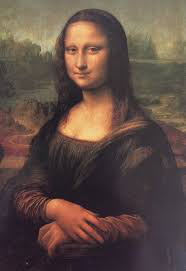

In [320]:
lisa

In [309]:
def k_way_tournament_selection(population, number_of_winners, K=3):
    selected = []
    while len(selected) < number_of_winners:
        fighters = random.choices(population, k=min(number_of_winners-len(selected), K))
        
        selected.append(min(fighters))
            
    return selected

In [336]:
EPOCHS = 1000
POP_SIZE = 100
DNA_SIZE = 100
MUTATION_CHANCE = 0.3
MUTATION_RATIO = 0.25
SELECTION_RATIO = 0.3

pop = Painting.random_population(POP_SIZE, DNA_SIZE, lisa)
initial = time()

for ep in range(EPOCHS):
    pop = [p.fit() for p in pop]
    pop = sorted(pop)
    best = pop[0]
    
    # Select
    selected = k_way_tournament_selection(pop, int(POP_SIZE * SELECTION_RATIO))
    
    # Reproduce
    children = []
    while len(children) < POP_SIZE:
        indA = random.choice(selected)
        indB = random.choice(selected)
        cross = Painting.crossover(indA, indB, 0.5)
        
        children.append(cross)
    
    # Mutate
    children = [child.mutate(MUTATION_CHANCE, MUTATION_RATIO) for child in children]
    
    # Elitism
    children.append(best)
    
    pop = children
    
    t = time()
    print(f'EPOCH: {ep} | SIZE: {len(pop)} | ELAPSED: {round(t - initial, 2)}s | BEST: {best.fitness}')

EPOCH: 0 | SIZE: 101 | ELAPSED: 0.43s | BEST: 99.09721726249519
EPOCH: 1 | SIZE: 101 | ELAPSED: 0.93s | BEST: 99.09721726249519
EPOCH: 2 | SIZE: 101 | ELAPSED: 1.33s | BEST: 99.09721726249519
EPOCH: 3 | SIZE: 101 | ELAPSED: 1.75s | BEST: 99.09721726249519
EPOCH: 4 | SIZE: 101 | ELAPSED: 2.25s | BEST: 99.09721726249519
EPOCH: 5 | SIZE: 101 | ELAPSED: 2.67s | BEST: 99.09721726249519
EPOCH: 6 | SIZE: 101 | ELAPSED: 3.18s | BEST: 99.09721726249519
EPOCH: 7 | SIZE: 101 | ELAPSED: 3.59s | BEST: 99.06695631472444
EPOCH: 8 | SIZE: 101 | ELAPSED: 3.99s | BEST: 98.09149043103334
EPOCH: 9 | SIZE: 101 | ELAPSED: 4.5s | BEST: 98.09149043103334
EPOCH: 10 | SIZE: 101 | ELAPSED: 4.91s | BEST: 98.09149043103334
EPOCH: 11 | SIZE: 101 | ELAPSED: 5.41s | BEST: 98.09149043103334
EPOCH: 12 | SIZE: 101 | ELAPSED: 5.81s | BEST: 98.09149043103334
EPOCH: 13 | SIZE: 101 | ELAPSED: 6.23s | BEST: 98.09149043103334
EPOCH: 14 | SIZE: 101 | ELAPSED: 6.72s | BEST: 97.01952148553744
EPOCH: 15 | SIZE: 101 | ELAPSED: 7.1

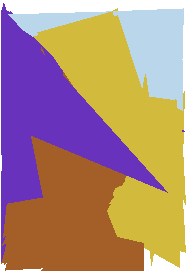

In [337]:
best.canvas

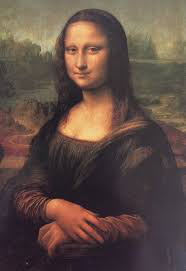

In [333]:
lisa

In [340]:
Painting._mse(lisa, best.canvas)

0.0